In [ ]:
!git clone https://github.com/dakoyaki/transit-assignment-dakota.git

fatal: destination path 'transit-assignment-dakota' already exists and is not an empty directory.


In [ ]:
# Install dependencies not in Google Colab
!pip install geopandas
!pip install folium
!pip install plotly_express
!pip install rtree
!pip install pygeos
!pip install folium -U

Requirement already up-to-date: folium in /usr/local/lib/python3.7/dist-packages (0.12.1)


In [ ]:
import pandas as pd
import geopandas as gpd
from functools import reduce
from shapely.geometry import Point, LineString
import plotly_express as px
import rtree
import pygeos
import datetime
import numpy as np

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data prep

## Data file

In [ ]:
# Open the data file
df = pd.read_csv('/content/transit-assignment-dakota/interview_test.csv.gz')
#  • rt_trip_id: a unique ID for the bus journey. Note that a bus operating between a start and end stops has multiple rt_trip_ids. Each unique journey between start and end has a unique rt_trip_id.
#  • rt_stop_id:  a unique ID for a stop in a city
#  • stop_offset: the order of the stop for that bus journey. A bus trip starts with stop_offset zero
#  • departure: the departure of that bus at that stop. The timestamp is in epoch UTC. Note that the current data is from Montreal time zone. The departure time is inferred, rather than known exactly.
#  • lat: latitude of the stop
#  • lng: longitude of the stop
#  • distance_prev: the distance that the bus drove in meters between the current stop and the previous stop.

f'There are {len(df)} records.'

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



'There are 600323 records.'

Plan: 

Predict speed then apply that to distance. 

### Pre-check

#### Check for duplicates

First, I check for any duplicate values in the data droping any rows with the same stop_id and stop_offset and trip_id and departure keeping the first value.

In [ ]:
# Check for duplicates
duplicates = df.duplicated(keep='first').sum()

print(f'Based on the criteria, there are {duplicates} duplicate records of the total {len(df)} records.')

Based on the criteria, there are 10848 duplicate records of the total 600323 records.


In [ ]:
# Drop duplicates
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

print(f"New record total: {len(df)}")

New record total: 589475


Then I run a basic describe and nan count

In [ ]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589475 entries, 0 to 589474
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   rt_trip_id     589475 non-null  object 
 1   rt_stop_id     589475 non-null  int64  
 2   stop_offset    589475 non-null  int64  
 3   departure      589475 non-null  int64  
 4   lat            589475 non-null  float64
 5   lng            589475 non-null  float64
 6   distance_prev  573460 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 31.5+ MB


In [ ]:
# describe
df.describe()

rt_stop_id    stop_offset  ...            lng  distance_prev
count  5.894750e+05  589475.000000  ...  589475.000000  573460.000000
mean   5.459546e+04      21.091716  ...     -73.632399     299.472213
std    3.186078e+04      15.615622  ...       0.086572     533.089874
min    3.000000e+00       0.000000  ...     -73.956201      13.000000
25%    5.200300e+04       9.000000  ...     -73.664687     179.000000
50%    5.430900e+04      18.000000  ...     -73.615494     238.000000
75%    5.663100e+04      30.000000  ...     -73.573657     314.000000
max    9.999495e+06     116.000000  ...     -73.480578   18169.000000

[8 rows x 6 columns]

In [ ]:
# Check counts of Nan
print(df.isna().sum())

rt_trip_id           0
rt_stop_id           0
stop_offset          0
departure            0
lat                  0
lng                  0
distance_prev    16015
dtype: int64


Distance_prev is the only one with missing values. Since this variable is important in calculating speed, I will try to fill it.

In [ ]:
# missing_count = len(df[df['distance_prev'].isna()]) 
# print(f'There are {missing_count} records missing the distance_prev field.')

I will use a polynomial interpolation to fill these null values

In [ ]:
# # To fill some of the NaN values for distance, I tool the mean of other distance_prev with lat/lng matching the same stop
# df['distance_prev'].interpolate(method='polynomial', order=2, inplace=True)
# print("Done")

In [ ]:
# missing_count = len(df[(df['distance_prev'].isna())])
# print(f'There are {missing_count} records still missing the distance_prev field.')

There are still 2 records missing fields. So, I will just drop those.

In [ ]:
# # Check counts of Nan
# df.dropna(subset=['distance_prev'],inplace=True)
# print(df.isna().sum())

On a previous run, I tried to calcualte this value, but after low accuracies I decided to skip this step and just drop any row with a missing distnace_prev

In [ ]:
df.dropna(subset=['distance_prev'],inplace=True)

### Transforming

#### Some new variables and edits

I need to add/change a few variables to the dataframe to make other analyses easier. 

In [ ]:
# Sort the df
df.sort_values(by=['rt_trip_id','stop_offset'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)

# First, convert the departure time to Montreal time
df['departure'] = df['departure']-14400 #convert to Montreal time. Montreal time is 14400 seconds behind UTC
print('Success! Converted the time to Montreal time.')

# Add the departure time from the previous stop
# If the previous stop is not one offset before then it is returned as NaN since that data wouldn't be accurate
# This works due to the sorting of the fields but would be good to brainstorm a more anti-fragile way
df['departure_prev'] = np.where(((df['stop_offset']-1) == df['stop_offset'].shift(1)) & (df['rt_trip_id'].shift(1) == df['rt_trip_id']), df['departure'].shift(1), None)
print("The departure time of the previous stop has been added to the dataframe")

# Convert both the departure time and previous stop depature time to ISO
# No super real reason for this... just easier to cross-check 
df['departure_iso'] = pd.to_datetime(df['departure'], unit='s')
df['time_dept_prev_iso'] = pd.to_datetime(df['departure_prev'], unit='s')
print("Times have been converted to ISO.")

# Get the time traveled in minutes between the two stops
# More specifcially, this is the time between departure time and departure time. 
df['time_traveled_m'] = (df['departure']-df['departure_prev'])/60 # in minutes
print("The time from departure A to departure B has been calculated.")

# Calculate the speed between point A and B
df['speed_m/min'] = (df['distance_prev']/df['time_traveled_m'])
print("The speed has been calculated.")

# Get the departure time
df['departure_time'] = pd.to_datetime(df['departure_iso'],format).apply(lambda x: x.time())
print("The departure time was added.")

# Get the hour of the departure
df['departure_hour'] = df['departure_iso'].apply(lambda x: x.hour)
print("The departure hour has been split out.")

Success! Converted the time to Montreal time.
The departure time of the previous stop has been added to the dataframe
Times have been converted to ISO.
The time from departure A to departure B has been calculated.
The speed has been calculated.
The departure time was added.
The departure hour has been split out.


Check the null values after adding new values. There are a few that have null's, but I am thinking they  are the first stop on the line so they  wouldn't be able to get the previous stop data.

In [ ]:
# Check nans
print(df.isna().sum())

rt_trip_id                0
rt_stop_id                0
stop_offset               0
departure                 0
lat                       0
lng                       0
distance_prev             0
departure_prev        19998
departure_iso             0
time_dept_prev_iso    19998
time_traveled_m       19998
speed_m/min           19998
departure_time            0
departure_hour            0
dtype: int64


In [ ]:
first_stop = len(df[(df['stop_offset']==0)])
print(f'There are {first_stop} records that are stop_offset 0.')

There are 0 records that are stop_offset 0.


I will keep these now until after data enrichment, then will decide to delete or keep.

#### Convert to geodataframe

I converted the dataframe to a geodataframe to process it a bit easier.

In [ ]:
# Build a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
print('GeoDataFrame succesfully built')
gdf.head()

GeoDataFrame succesfully built


rt_trip_id  rt_stop_id  ...  departure_hour                    geometry
0  201874894       60693  ...               0  POINT (-73.55250 45.44884)
1  201874894       60694  ...               0  POINT (-73.54983 45.45044)
2  201874894       56654  ...               0  POINT (-73.54689 45.45331)
3  201874894       56656  ...               0  POINT (-73.54573 45.45435)
4  201874894       56663  ...               0  POINT (-73.54303 45.45638)

[5 rows x 15 columns]

### Data enrichment

#### Districts

In [ ]:
# Open the Montreal shapefile to get the districts
montreal_shp_zip = "zip:///content/transit-assignment-dakota/montreal_shapefile.zip"
montreal_districts = gpd.read_file(montreal_shp_zip)
# montreal_districts
print('The Montreal district shapefile has been loaded.')

The Montreal district shapefile has been loaded.


In [ ]:
# Spatially join the montreal_districts to the main gdf to get the disctricts the stops are in
gdf = gpd.sjoin(gdf, montreal_districts, how='inner', op='within')
gdf.drop(columns=['index_right', 'type'], inplace=True) #Drop the index_right field to clean it up
print('Spatial join successful!')
gdf.head()

Spatial join successful!


rt_trip_id  rt_stop_id  ...  cartodb_id  district
0  201874894       60693  ...          30    Verdun
1  201874894       60694  ...          30    Verdun
2  201874894       56654  ...          30    Verdun
3  201874894       56656  ...          30    Verdun
4  201874894       56663  ...          30    Verdun

[5 rows x 17 columns]

In [ ]:
#check for nan values for districts
print(gdf['district'].isna().sum())

0


yay

#### Street characteristics

In [ ]:
# Road network shapefile
network_shp_zip = "zip:///content/transit-assignment-dakota/road network.zip"
network_shp = gpd.read_file(network_shp_zip)

# Add 10m buffer to catch the stops as bus stops are typically not in the middle of the street
# This buffer is a little large, but there is another line of code to catch any issues with duplicate joins
network_shp['geometry'] = network_shp.geometry.buffer(10)
network_shp = network_shp.to_crs("EPSG:4326") 

print('Road network shapefile has been uploaded.')

Road network shapefile has been uploaded.


In [ ]:
# Spatial join the gdf to road network
gdf = gpd.sjoin(gdf, network_shp, how="left", op='intersects')

# Drops any duplicates that were caught from the road overlapping, but keeps the first interection found
gdf.drop_duplicates(subset=["rt_trip_id", "rt_stop_id", "stop_offset", "departure"], keep='first',inplace=True)

# Clean up the unnecessary columns
gdf.drop(columns=['index_right','ID_TRC','DEB_GCH','FIN_GCH','ARR_GCH','SENS_CIR','LIE_VOIE','NOM_VOIE','DEB_DRT', 'FIN_DRT', 'ARR_DRT', 'LIM_GCH', 'LIM_DRT','DIR_VOIE'], inplace=True)
# Rename some columns. Just housekeeping
gdf.rename(columns={"CLASSE": "street_class", "TYP_VOIE": "street_type"}, inplace=True)

print('Spatial join was completed and cleaned')

# gdf.to_csv('/content/drive/MyDrive/Transit - Interview test/trip_data_joined.csv', index=False)
# print('The spatial join was sucessfully saved as a csv file.')

Spatial join was completed and cleaned


In [ ]:
# Check for nan values for districts
print(gdf.isna().sum())

rt_trip_id                0
rt_stop_id                0
stop_offset               0
departure                 0
lat                       0
lng                       0
distance_prev             0
departure_prev        19998
departure_iso             0
time_dept_prev_iso    19998
time_traveled_m       19998
speed_m/min           19998
departure_time            0
departure_hour            0
geometry                  0
cartodb_id                0
district                  0
street_class           8147
street_type            9070
dtype: int64


There are missing values for both street class and type but I will deal with those after the next section.

#### Some new variables and edits


In [ ]:
# Get the previous street class and types
gdf['street_class_prev'] = np.where(((gdf['stop_offset']-1) == gdf['stop_offset'].shift(1)) & (gdf['rt_trip_id'].shift(1) == gdf['rt_trip_id']), gdf['street_class'].shift(1), None)
gdf['street_type_prev'] = np.where(((gdf['stop_offset']-1) == gdf['stop_offset'].shift(1)) & (gdf['rt_trip_id'].shift(1) == gdf['rt_trip_id']), gdf['street_type'].shift(1), None)
print("The previous street class and types have been added.")

# To begin handling NaN values, if they are NaN then their current street type and class is used
# There is a high chance that it's the same
gdf['street_class_prev'].fillna(gdf['street_class'],inplace=True)
gdf['street_type_prev'].fillna(gdf['street_type'],inplace=True)
gdf['street_class'].fillna(gdf['street_class_prev'],inplace=True)
gdf['street_type'].fillna(gdf['street_type_prev'],inplace=True)
print("The null values were filled.")

# Now I check if stop A and stop B have the same street type and class
gdf['same_class'] = np.where((gdf['street_class_prev'] == gdf['street_class']), 1, 0)
gdf['same_type'] = np.where((gdf['street_type_prev'] == gdf['street_type']), 1, 0)
print("The street type/class comparison fields were made.")

The previous street class and types have been added.
The null values were filled.
The street type/class comparison fields were made.


In [ ]:
# Check the gdf
gdf.head()

rt_trip_id  rt_stop_id  stop_offset  ...  street_type_prev  same_class  same_type
0  201874894       60693            1  ...            chemin           1          1
1  201874894       60694            2  ...            chemin           1          1
2  201874894       56654            3  ...            chemin           0          0
3  201874894       56656            4  ...         boulevard           1          1
4  201874894       56663            5  ...         boulevard           1          1

[5 rows x 23 columns]

### Cleaning

Now, I will deal with the nan street characteristic values...


To get a better idea of where the nan values are, I decided to plot them. I chose to focus on street type here.

In [ ]:
import folium
import pandas as pd

#create a map
montreal_map_stops = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles='cartodbpositron')

def plotDot(point):
  folium.CircleMarker(location=[point.lat, point.lng],
                        radius=2,
                        weight=5,
                        tooltip=point.rt_stop_id).add_to(montreal_map_stops)

gdf[gdf['street_type'].isna()].apply(plotDot, axis = 1)

montreal_map_stops

It really didn't look like a lot... so I decided to use the time to manually add the street types in then will use interpolation to find the classes. 

In [ ]:
# Avoiding typos...
gdf['street_type'].unique()

array(['chemin', 'boulevard', 'autoroute', 'place', 'rue', 'avenue', nan,
       'voie', 'côte', None, 'tunnel', 'terrasse', 'allée', 'croissant',
       'route', 'cercle', 'cours', 'montée'], dtype=object)

In [ ]:
# Make a list of the nan stop id's and their street type
boulevard = [58268,58237,58245,58244,58290,58291,58137,58136,58143,58141,58270,61684,59284,56227,56226,56229,56230,56233,56234,56241,56240,56248,56247,56260,56259,56264,56265,56269,56268,51680,51681,51716]
rue = [58590,58577,53963,61173,61174,59034,59316]
avenue = [54224,54159,61788]
chemin = [51347,56224]

# Update the datframe
gdf['street_type'] = np.where(gdf['rt_stop_id'].isin(boulevard), 'boulevard', gdf['street_type'])
gdf['street_type'] = np.where(gdf['rt_stop_id'].isin(rue), 'rue', gdf['street_type'])
gdf['street_type'] = np.where(gdf['rt_stop_id'].isin(avenue), 'avenue', gdf['street_type'])
gdf['street_type'] = np.where(gdf['rt_stop_id'].isin(chemin), 'chemin', gdf['street_type'])

There are still some stop's street types that were not manually coded but those were either in a strange location or unable to zoom close enough to see their street type. So, I will drop the remaining nan rows at the end of this section to avoid issues.

In [ ]:
# Remove NaN for street type
gdf.dropna(subset=['street_type'],inplace=True)

To fill in the street class I will use polynomial interpolation

In [ ]:
gdf['street_class'].interpolate(method='polynomial', order=1, inplace=True)
gdf['street_class'] = round(gdf['street_class']) 

In [ ]:
# Check nans
print(gdf.isna().sum())

rt_trip_id                0
rt_stop_id                0
stop_offset               0
departure                 0
lat                       0
lng                       0
distance_prev             0
departure_prev        19629
departure_iso             0
time_dept_prev_iso    19629
time_traveled_m       19629
speed_m/min           19629
departure_time            0
departure_hour            0
geometry                  0
cartodb_id                0
district                  0
street_class              0
street_type               0
street_class_prev      1121
street_type_prev       1947
same_class                0
same_type                 0
dtype: int64


To fix the stree_class_prev and street_type_prev, I will need to just rerun previously ran code. I was not able to run this code only now due to the removal of variabless.

In [ ]:
# Get the previous street class and types
gdf['street_class_prev'] = np.where(((gdf['stop_offset']-1) == gdf['stop_offset'].shift(1)) & (gdf['rt_trip_id'].shift(1) == gdf['rt_trip_id']), gdf['street_class'].shift(1), None)
gdf['street_type_prev'] = np.where(((gdf['stop_offset']-1) == gdf['stop_offset'].shift(1)) & (gdf['rt_trip_id'].shift(1) == gdf['rt_trip_id']), gdf['street_type'].shift(1), None)
print("The previous street class and types have been added.")

# To begin handling NaN values, if they are NaN then their current street type and class is used
# There is a high chance that it's the same
gdf['street_class_prev'].fillna(gdf['street_class'],inplace=True)
gdf['street_type_prev'].fillna(gdf['street_type'],inplace=True)
gdf['street_class'].fillna(gdf['street_class_prev'],inplace=True)
gdf['street_type'].fillna(gdf['street_type_prev'],inplace=True)
print("The null values were filled.")

# Now I check if stop A and stop B have the same street type and class
gdf['same_class'] = np.where((gdf['street_class_prev'] == gdf['street_class']), 1, 0)
gdf['same_type'] = np.where((gdf['street_type_prev'] == gdf['street_type']), 1, 0)
print("The street type/class comparison fields were made.")

The previous street class and types have been added.
The null values were filled.
The street type/class comparison fields were made.


In [ ]:
print(gdf.isna().sum())

rt_trip_id                0
rt_stop_id                0
stop_offset               0
departure                 0
lat                       0
lng                       0
distance_prev             0
departure_prev        19629
departure_iso             0
time_dept_prev_iso    19629
time_traveled_m       19629
speed_m/min           19629
departure_time            0
departure_hour            0
geometry                  0
cartodb_id                0
district                  0
street_class              0
street_type               0
street_class_prev         0
street_type_prev          0
same_class                0
same_type                 0
dtype: int64


#### One stop trips

I wanted to check how many trips only have 1 stop. Since a 1 stop trip isn't able to give me distance data or A/B departure times, I decide to drop them. 

In [ ]:
# Create dataframe for metrics by trip
# Count of stops per trip
trip_data = gdf.groupby('rt_trip_id').agg({'rt_stop_id':'count'})
trip_data.rename(columns={"rt_stop_id": "stop_count"}, inplace=True)

print(f"There are {len(trip_data[trip_data['stop_count']<=1])} trips with one (or less) stops.")

There are 135 trips with one (or less) stops.


In [ ]:
# Erase those with <=1 with a mask
one_stop_trip = trip_data[trip_data["stop_count"] <= 1]
bad_trip_list = one_stop_trip.index #Get list of trips to delete

gdf = gdf[~gdf['rt_trip_id'].isin(bad_trip_list)]

# reset the group to check again
trip_data = gdf.groupby('rt_trip_id').agg({'rt_stop_id':'count'})
trip_data.rename(columns={"rt_stop_id": "stop_count"}, inplace=True)
trip_data.describe()

print(f"There are {len(trip_data[trip_data['stop_count']<=1])} trips with one (or less) stops.")

There are 0 trips with one (or less) stops.


There are some trips with 2 stops... but that is atleast one point set I can use. 

#### Check for non continuous trips

The next potential issue is that I need to check if there are trip_ids that have offsets that are not continous. That creates issues when looking at the distance traveled since there is a midway point missing. 

In [ ]:
# I check if the previous trip_id is the same and if the offset is not one before, creating a mask
# Agin, this works due to the sorted fields... it needs a less fragile approach to be improved.

# Looking for records with the same trip_id and the previous stop_offset not being one less than the current
not_continuous = gdf[((gdf['rt_trip_id'] == gdf['rt_trip_id'].shift(1)) & ((gdf['stop_offset']-1) != (gdf['stop_offset'].shift(1))))]
no_prev_stop = len(not_continuous)
print(f'There are {no_prev_stop} records with no previous stop')

There are 5791 records with no previous stop


In [ ]:
non_continuous_list = not_continuous.index #Get list of trips to delete
gdf = gdf[~gdf.index.isin(non_continuous_list)]

gdf.reset_index(inplace=True)
gdf.drop(['index'], axis=1, inplace=True)

print('The records without a previous stop have been dropped.')

The records without a previous stop have been dropped.


In [ ]:
# Check nans
print(gdf.isna().sum())

rt_trip_id                0
rt_stop_id                0
stop_offset               0
departure                 0
lat                       0
lng                       0
distance_prev             0
departure_prev        17165
departure_iso             0
time_dept_prev_iso    17165
time_traveled_m       17165
speed_m/min           17165
departure_time            0
departure_hour            0
geometry                  0
cartodb_id                0
district                  0
street_class              0
street_type               0
street_class_prev         0
street_type_prev          0
same_class                0
same_type                 0
dtype: int64


#### Check for outliers

**NOTE**

*I ran the model with dropping outliers and it decreased the accuracy. So, I skipped this step the second time.*

Since speed is a standardized value of the time and distance between stops, I ignored any outliers in both of those variables.

Likewise, since I am focusing on a prediction model for speed, I instead focused on that. 

I decided to use the IQR method. 

I also decided to do this last so that I could still capture some off the data even if one of the removed outliers breaks up trip.


In [ ]:
# # Get IQR for speed
# q1 = gdf['speed_m/min'].quantile(0.10)
# q2 = gdf['speed_m/min'].quantile(0.90)
# IQR = q2 - q1
# print(IQR)

In [ ]:
# # Create an outlier mask
# outliers = ((gdf['speed_m/min'] < (q1 - 1.5 * IQR)) | (gdf['speed_m/min'] > (q2 + 1.5 * IQR)))
# print(f"There are {len(outliers[outliers==True])} outliers in the speed_m/min field.")

In [ ]:
# # Remove outliers
# gdf = gdf[~(outliers)]

# gdf.reset_index(inplace=True)
# gdf.drop(['index'], axis=1, inplace=True)

In [ ]:
# # Count outliers again
# outliers = ((gdf['speed_m/min'] < (q1 - 1.5 * IQR)) | (gdf['speed_m/min'] > (q2 + 1.5 * IQR)))
# print(f"There are {len(outliers[outliers==True])} outliers in the speed_m/min field. And a total of {len(gdf)} records.")

#### Checking Nan



I will remove all of the records with departure_prev missing since that isn't easily possible to accurately calculate.

In [ ]:
gdf[gdf['departure_prev'].isna()]

rt_trip_id  rt_stop_id  ...  same_class  same_type
0       201874894       60693  ...           1          1
32      201874897       60693  ...           1          1
69      201875131       56689  ...           1          1
115     201875180       61564  ...           1          1
136     201875203       56641  ...           1          1
...           ...         ...  ...         ...        ...
565970  204063598       60316  ...           1          1
565990  204064047       52927  ...           1          1
566017  204064273       52927  ...           1          1
566041  204064286       53225  ...           1          1
566134  204905415       60316  ...           1          1

[17165 rows x 23 columns]

In [ ]:
gdf = gdf[gdf['departure_prev'].notna()]
gdf.isna().sum()

rt_trip_id            0
rt_stop_id            0
stop_offset           0
departure             0
lat                   0
lng                   0
distance_prev         0
departure_prev        0
departure_iso         0
time_dept_prev_iso    0
time_traveled_m       0
speed_m/min           0
departure_time        0
departure_hour        0
geometry              0
cartodb_id            0
district              0
street_class          0
street_type           0
street_class_prev     0
street_type_prev      0
same_class            0
same_type             0
dtype: int64

#### Check data types

In [ ]:
gdf.dtypes

rt_trip_id                    object
rt_stop_id                     int64
stop_offset                    int64
departure                      int64
lat                          float64
lng                          float64
distance_prev                float64
departure_prev                object
departure_iso         datetime64[ns]
time_dept_prev_iso    datetime64[ns]
time_traveled_m               object
speed_m/min                   object
departure_time                object
departure_hour                 int64
geometry                    geometry
cartodb_id                     int64
district                      object
street_class                 float64
street_type                   object
street_class_prev            float64
street_type_prev              object
same_class                     int64
same_type                      int64
dtype: object

In [ ]:
# Fix types
gdf['speed_m/min'] = gdf['speed_m/min'].astype(str).astype(float)

In [ ]:
# gdf.to_csv('/content/drive/MyDrive/Transit - Interview test/cleaned_data.csv')

# Splitting

I decided to split the data now so that I can get a more realistic test at predicting unknowns.

I am going to get a sample of 80% of the total dataset.

In [ ]:
# # 80% of gdf
# split_amount = round(len(gdf)*.8)
# split_amount

# gdf_train = gdf

In [ ]:
# gdf_train.reset_index(inplace=True,drop=True)
# gdf_train

# Exploration

### Time exploration

The first temporal exploration I wanted to do was to look more closly at the trends of trips (count) and speeds (mean)

In [ ]:
# Copy the gdf to have something to play with
time_df = gdf.copy()

time_df['departure'] = pd.to_datetime(time_df['departure_iso'], format="%H:%M:%S")

time_df.set_index("departure", inplace=True)

#### By hour




In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
time_df_hr = time_df.groupby(pd.Grouper(freq='60Min',closed='right',label='right')).agg({"rt_trip_id":  "count","speed_m/min":  "mean"})

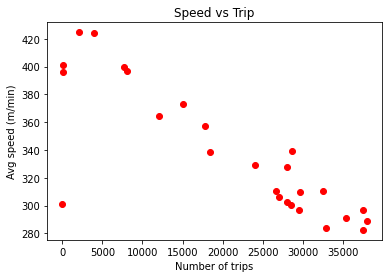

In [ ]:
from matplotlib import pyplot as plt

data = time_df_hr.copy()
# separate into input and output columns
X = data['rt_trip_id'].values.reshape(-1, 1)
y = data['speed_m/min'].values

#ploting the dataset
#for ploting the data  for train data
plt.scatter(X,y,color='red')
plt.title("Speed vs Trip")
plt.ylabel("Avg speed (m/min)")
plt.xlabel("Number of trips")
plt.show()

The relationship between trip count an avg speed isn't a surprise as all since increased trip count usually corresponds with rush hour traffic... which also has slower speeds...

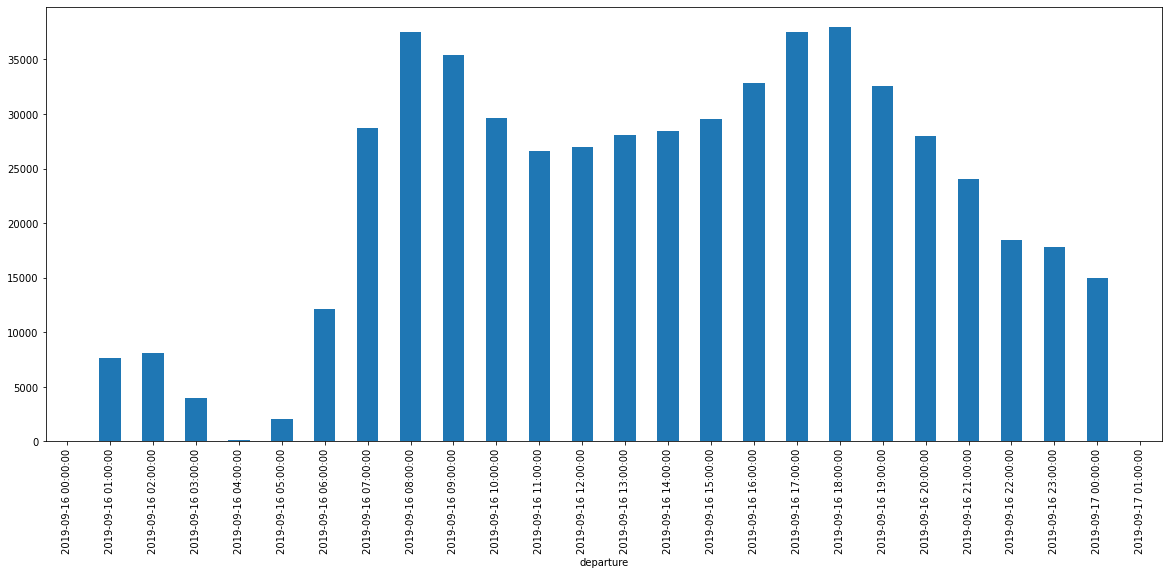

In [ ]:
time_df_hr['rt_trip_id'].plot(kind='bar',figsize=(20,8),legend=None)

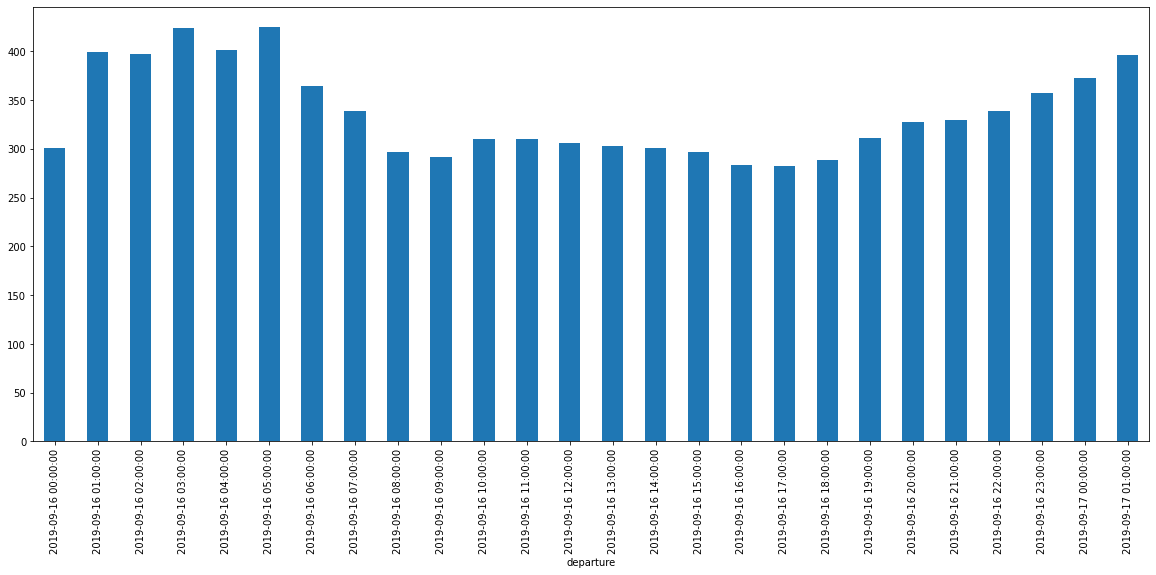

In [ ]:
time_df_hr['speed_m/min'].plot(kind='bar',figsize=(20,8),legend=None)

#### By 15min intervals

I decided to break the time down to 15 minute intervals to get a more detailed look at the temporal trends. 

In [ ]:
# Get a count of trips by 15 min block
time_df_min = time_df.groupby(pd.Grouper(freq='15Min',closed='right',label='right')).agg({"rt_trip_id":  "count","speed_m/min":  "mean"})

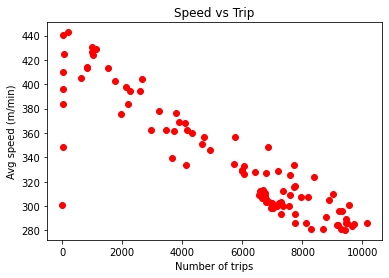

In [ ]:
from matplotlib import pyplot as plt

data = time_df_min.copy()
# separate into input and output columns
X = data['rt_trip_id'].values.reshape(-1, 1)
y = data['speed_m/min'].values

#ploting the dataset
#for ploting the data  for train data
plt.scatter(X,y,color='red')
plt.title("Speed vs Trip")
plt.ylabel("Avg speed (m/min)")
plt.xlabel("Number of trips")
plt.show()

In [ ]:
time_df_min.describe()

rt_trip_id  speed_m/min
count     98.000000    98.000000
mean    5602.102041   336.078664
std     3028.106364    46.188972
min        5.000000   280.460321
25%     3276.750000   300.716107
50%     6713.500000   320.189811
75%     7734.250000   367.139958
max    10139.000000   442.695506

In [ ]:
# I did notice a few "outliers"
# Remove rows that the trip count is < 30
time_df_min.drop(time_df_min[time_df_min.rt_trip_id < 30].index, inplace=True)
print("Trip count outliers were removed")

Trip count outliers were removed


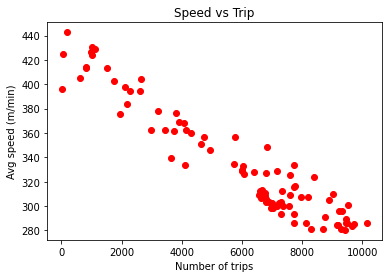

In [ ]:
data = time_df_min.copy()
# separate into input and output columns
X = data['rt_trip_id'].values.reshape(-1, 1)
y = data['speed_m/min'].values

#ploting the dataset
#for ploting the data  for train data
plt.scatter(X,y,color='red')
plt.title("Speed vs Trip")
plt.ylabel("Avg speed (m/min)")
plt.xlabel("Number of trips")
plt.show()

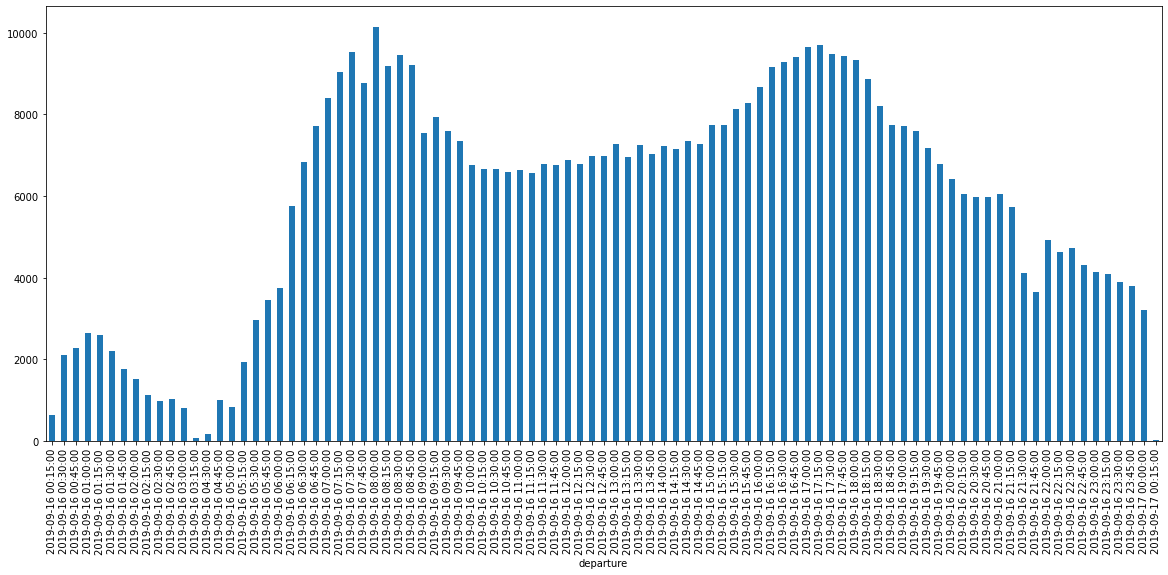

In [ ]:
time_df_min['rt_trip_id'].plot(kind='bar',figsize=(20,8),legend=None)

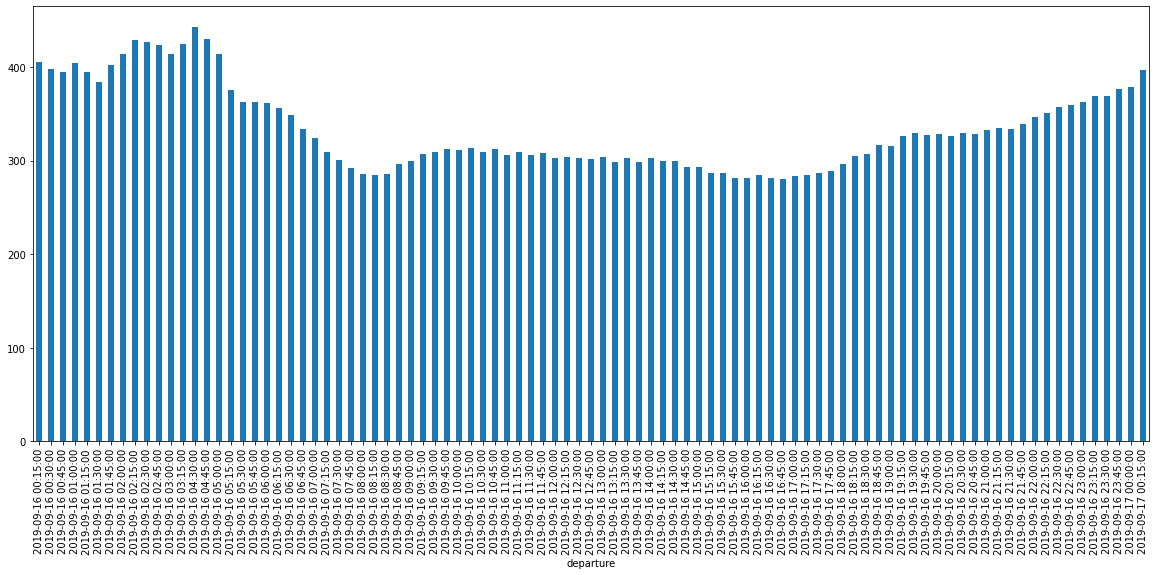

In [ ]:
time_df_min['speed_m/min'].plot(kind='bar',figsize=(20,8),legend=None)

In [ ]:
time_df_min.reset_index(inplace=True)
time_df_min['departure'] = pd.to_datetime(time_df_min['departure'],format).apply(lambda x: x.time())

After exploring the time aspects of the data, I decided to go with the 15 min interval data since it is a bit more detailed and has more pronounced trends. 


So, I rejoin this back into the main geodataframe by time so I can do some spatial exploration.

#### Rejoining new time data to old geodataframe

In [ ]:
time_df_min.head()

departure  rt_trip_id  speed_m/min
0  00:15:00         635   405.274742
1  00:30:00        2117   397.928820
2  00:45:00        2272   394.822379
3  01:00:00        2660   403.936585
4  01:15:00        2606   394.269781

In [ ]:
# First, I needed to create a field in the dataframe that could be joined
gdf['departure_15_min'] = gdf['departure_iso'].dt.round('15min')  
gdf['departure_15_min'] = pd.to_datetime(gdf['departure_15_min'],format).apply(lambda x: x.time())

In [ ]:
# time_df_min.reset_index(inplace=True)
# time_df_min['departure'] = pd.to_datetime(time_df_min['departure'],format).apply(lambda x: x.time())


In [ ]:
gdf = gdf.merge(time_df_min, left_on='departure_15_min', right_on='departure')

# Housekeeping
gdf.rename(columns={"rt_trip_id_y": "trip_trip_count", "speed_m/min_y": "trip_speed_avg","rt_trip_id_x": "rt_trip_id", "speed_m/min_x": "speed_m/min"}, inplace=True)

In [ ]:
gdf.head()

### Spatial exploration

#### Street class

Compare time and speed to road type and class


I decided to focus most on speed since it's easy to use that to predict the eta. 

ie. x is 1km away, our speed is 1km/hr, ETA to x is 1 hour.

In [ ]:
import plotly.express as px

class_grouping = gdf.groupby('street_class').agg({'speed_m/min':'mean'})
class_grouping.sort_values(by=['speed_m/min'],inplace=True)

class_grouping.rename(columns={"speed_m/min": "Avg speed"}, inplace=True)

print("This figure shows the overall average speed per trip in each street class.")

speed_fig = px.bar(class_grouping, x=class_grouping.index, y=class_grouping['Avg speed'],
             color=class_grouping['Avg speed'], labels={'x':'Class','Avg speed':'Avg Speed (m/min)'})
speed_fig.show()

This figure shows the overall average speed per trip in each street class.


In [ ]:
# Get more info on the relationship between each class and the time it took the bus to get from departure time A and departure time B

# Get one hot encoding of road class
class_one_hot = pd.get_dummies(gdf['street_class']).add_prefix('class_')

# Join the encoded df
class_gdf = gdf.copy()

class_gdf = class_gdf.join(class_one_hot)

# class_gdf.head()

In [ ]:
# Build a temporary dataframe to build scatterplots
col_list = ['speed_m/min', 
            'class_0.0', 
            'class_1.0', 
            'class_2.0', 
            'class_4.0',	
            'class_5.0',	
            'class_6.0',	
            'class_7.0',	
            'class_8.0']

class_df = class_gdf[col_list]

In [ ]:
# CODE THE STREET TYPE
# This will generate a dataframe for the street type coding
# Again, not super sexy but it's quick and easy 
class_mapping = class_grouping #This exists from earlier
class_mapping = class_mapping.sort_values(by="Avg speed", ascending=False)
class_mapping.reset_index(inplace=True)

class_mapping['class_category'] = (class_mapping.index + 1)/len(class_mapping)
class_mapping.drop(columns=['Avg speed'], inplace=True)

# Merge the datasets, easier than mapping
class_coded = pd.merge(gdf, class_mapping['class_category'], left_on=['street_class'], right_on = class_mapping['street_class'], how = 'left')
class_coded = class_coded[['class_category','speed_m/min']]

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = class_coded

# get the labels
y = data['speed_m/min'].values
data = data.drop(['speed_m/min'], axis=1)
x = data.values

x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(x, y)

# Use the forest's predict method on the test data
y_pred = reg.predict(x_test)

# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Print out the mean absolute error (mae)
print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print(f'The rmse of prediction is: {round(mean_squared_error(y_test, y_pred) ** 0.5,2)}')
print(f'Accuracy: {round(accuracy, 2)}%.')

Mean Absolute Error: 95.17
The rmse of prediction is: 125.61
Accuracy: 62.77%.


Nothing super impressive with the correlations

#### Street type

In [ ]:
type_grouping = gdf.groupby('street_type').agg({'speed_m/min':'mean'})

type_grouping.sort_values(by=['speed_m/min'],inplace=True)

type_grouping.rename(columns={"speed_m/min": "Avg speed"}, inplace=True)
# type_grouping

import plotly.express as px
# traveled_fig = px.bar(type_grouping, x=type_grouping.index, y=type_grouping['Avg distance traveled'],
#              color=type_grouping['Avg distance traveled'], labels={'x':'Type','Avg distance traveled':'Avg distance traveled (m)'})
# traveled_fig.show()

# traveled_fig = px.bar(type_grouping, x=type_grouping.index, y=type_grouping['Avg time traveled'],
#              color=type_grouping['Avg time traveled'], labels={'x':'Type','Avg Time traveled':'Avg Time traveled (min)'})
# traveled_fig.show()

speed_fig = px.bar(type_grouping, x=type_grouping.index, y=type_grouping['Avg speed'],
             color=type_grouping['Avg speed'], labels={'x':'Type','Avg speed':'Avg Speed (m/min)'})
speed_fig.show()

In [ ]:
# Get more info on the relationship between each type and the speed

# Get one hot encoding of road type
type_one_hot = pd.get_dummies(gdf['street_type']).add_prefix('type_')

# Join the encoded df
type_gdf = gdf.copy()

type_gdf = class_gdf.join(type_one_hot)

# type_gdf.head()

In [ ]:
# Build a temporary dataframe to build scatterplots
col_list = ['speed_m/min', 
            'type_allée',
            'type_autoroute',
            'type_avenue',
            'type_boulevard',
            'type_cercle',
            'type_chemin',
            'type_cours',
            'type_croissant',
            'type_côte',
            'type_montée',
            'type_place',
            'type_route',
            'type_rue',
            'type_terrasse',
            'type_tunnel',
            'type_voie']

type_df = type_gdf[col_list]

In [ ]:
# CODE THE STREET TYPE
# This will generate a dataframe for the street type coding
# Again, not super sexy but it's quick and easy 
type_mapping = type_grouping #This exists from earlier
type_mapping = type_mapping.sort_values(by="Avg speed", ascending=False)
type_mapping.reset_index(inplace=True)

type_mapping['type_category'] = (type_mapping.index + 1)/len(type_mapping)
type_mapping.drop(columns=['Avg speed'], inplace=True)

# Merge the datasets, easier than mapping
type_coded = pd.merge(gdf, type_mapping['type_category'], left_on=['street_type'], right_on = type_mapping['street_type'], how = 'left')
type_coded = type_coded[['type_category','speed_m/min']]

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data = type_coded

# get the labels
y = data['speed_m/min'].values
data = data.drop(['speed_m/min'], axis=1)
x = data.values

x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(x, y)

# Use the forest's predict method on the test data
predictions = reg.predict(x_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print(f'The rmse of prediction is: {round(mean_squared_error(y_test, predictions) ** 0.5,2)}')
print(f'Accuracy: {round(accuracy, 2)}%.')

Mean Absolute Error: 95.49
The rmse of prediction is: 124.79
Accuracy: 62.61%.


Street class had a slightly better accuracy in predicting the speed, so I decided to drop the street type and only go with that. 

#### Street class change

Next, I wanted to look to see if the stop being on the same type of street type or class had a difference

In [ ]:
class_change = gdf.groupby('same_class').agg({'speed_m/min':'mean'})
class_change.sort_values(by=['speed_m/min'],inplace=True)


class_change.rename(columns={"speed_m/min": "Avg speed"}, inplace=True)
# class_change

import plotly.express as px
speed_fig = px.bar(class_change, x=class_change.index, y=class_change['Avg speed'],
             color=class_change['Avg speed'], labels={'x':'Same street class','Avg speed':'Avg Speed (m/min)'})
speed_fig.show()


A very slight decrease of ~8m/min if the street class is the same.

#### Street type change

In [ ]:
type_change = gdf.groupby('same_type').agg({'speed_m/min':'mean'})
type_change.sort_values(by=['speed_m/min'],inplace=True)


type_change.rename(columns={"speed_m/min": "Avg speed"}, inplace=True)
# type_change

import plotly.express as px

speed_fig = px.bar(type_change, x=type_change.index, y=type_change['Avg speed'],
             color=type_change['Avg speed'], labels={'x':'Type','Avg speed':'Avg Speed (m/min)'})
speed_fig.show()

About a ~20 meters/min decrease if the street class is the same

I was expecting the street type/class staying the same between stops to help keep speeds higher. 

As neither of these really made much difference, I decided to drop them both.

#### Districts

First, I made some graphs and maps to visualize each district

In [ ]:
montreal_districts_gdf = montreal_districts.merge(gdf, left_on='cartodb_id', right_on='cartodb_id')
# montreal_districts_gdf.drop(columns=['index'], inplace=True)

In [ ]:
from geopandas import GeoDataFrame as gdf

geometry = montreal_districts_gdf['geometry_x']
montreal_districts_gdf = gdf(montreal_districts_gdf, crs="EPSG:4326", geometry=geometry)

In [ ]:
# Create a grouped dataset to get aggregate data
district_grouping = montreal_districts_gdf.groupby('district_x').agg({'rt_stop_id':'nunique',
                                                 'speed_m/min':'mean',
                                                 'cartodb_id':'max'})
district_grouping.sort_values(by=['speed_m/min'],inplace=True)
district_grouping.rename(columns={"rt_stop_id": "Stop count", "speed_m/min": "Avg speed"}, inplace=True)

In [ ]:
import plotly.express as px
speed_fig = px.bar(district_grouping, x=district_grouping.index, y=district_grouping['Avg speed'],
             color=district_grouping['Avg speed'], labels={'x':'District','Avg speed':'Avg Speed (m/min)'})
speed_fig.show()

In [ ]:
# Build a dataset from the grouping that can be mapped
montreal_districts_gdf_plotting = montreal_districts.merge(district_grouping, left_on='cartodb_id', right_on='cartodb_id')

In [ ]:
import folium
from branca.colormap import linear

def disctricMap(variable):
    montreal_map_variable = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles='cartodbpositron')
  
    nbh_count_colormap = linear.YlGnBu_09.scale(min(montreal_districts_gdf_plotting[variable]),
                                                max(montreal_districts_gdf_plotting[variable]))
      
    style_function = lambda x: {
        'fillColor': nbh_count_colormap(x['properties'][variable]),
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.7
    }

    folium.GeoJson(
        montreal_districts_gdf_plotting,
        style_function=style_function,
        tooltip=folium.GeoJsonTooltip(
            fields=['district', 'Stop count','Avg speed'],
            aliases=['District', 'Stop count', 'Avg speed (m/min)'],
            localize=True
            )
        ).add_to(montreal_map_variable)

    folium.map.CustomPane('labels').add_to(montreal_map_variable)
    folium.TileLayer('CartoDBPositronOnlyLabels',
                    pane='labels').add_to(montreal_map_variable)

    nbh_count_colormap.add_to(montreal_map_variable)
    nbh_count_colormap.caption = variable
    nbh_count_colormap.add_to(montreal_map_variable)
    
    return montreal_map_variable

In [ ]:
print("This map represents the average speed irregardless of time.")
disctricMap('Avg speed')

This map represents the average speed irregardless of time.


## Random Forest - One hot encoding

I wanted to try Random Forest first since my method was naturally going down that route.

None of the variables were converted to anything other than hot encoding. So, this was by far the simplest algorithm. 

**Accuracy: 87.87%**

**Time: ~6min**


In [ ]:
data_train = df[['departure_15_min', 'district', 'street_class', 'speed_m/min']]

KeyError: ignored

In [ ]:
rf_data = data_train.copy()
rf_data.reset_index(inplace=True)

In [ ]:
# One-hot encode the data using pandas get_dummies
rf_data = pd.get_dummies(data=rf_data, columns=['district', 'departure_15_min','street_class', 'street_type'])

In [ ]:
# Use numpy to convert to arrays
import numpy as np

labels = np.array(rf_data['speed_m/min'])

# Remove rf_data
rf_data= rf_data.drop('speed_m/min', axis = 1)
# Saving feature names for later use
feature_list = list(rf_data.columns)
# Convert to numpy array
rf_data = np.array(rf_data)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(rf_data, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (338861, 154)
Training Labels Shape: (338861,)
Testing Features Shape: (112954, 154)
Testing Labels Shape: (112954,)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print(f'The rmse of prediction is: {round(mean_squared_error(test_labels, predictions) ** 0.5,2)}')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print(f'Accuracy: {round(accuracy, 2)}%.')


Mean Absolute Error: 39.73
Accuracy: 87.87%.


## Random forests - Coded variables




I wanted to go with coding the variables and testing the same model. There was a decent increase in both time and accuracy

**Accuracy: 88.47%**

**Time: ~30secs**

In [ ]:
coded_data = gdf
# Rush hour dummy varaiable
coded_data['rush_hour'] = coded_data['departure_time'].apply(lambda x: 1 if (x >= datetime.strptime('7:00','%H:%M').time() and x<= datetime.strptime('9:15','%H:%M').time()) or (x >= datetime.strptime('15:00','%H:%M').time() and x< datetime.strptime('18:00','%H:%M').time()) else 0)

# This will generate a dataframe for the street type coding
# Again, not super sexy but it's quick and easy 
type_mapping = type_grouping #This exists from earlier
type_mapping = type_mapping.sort_values(by="Avg speed", ascending=False)
type_mapping.reset_index(inplace=True)

type_mapping['type_category'] = type_mapping.index + 1
type_mapping.drop(columns=['Avg speed'], inplace=True)

# This will generate a dataframe for the street type coding
# Again, not super sexy but it's quick and easy 
class_mapping = class_grouping #This exists from earlier
class_mapping = class_mapping.sort_values(by="Avg speed", ascending=False)
class_mapping.reset_index(inplace=True)

class_mapping['class_category'] = class_mapping.index + 1
class_mapping.drop(columns=['Avg speed'], inplace=True)

# This will generate a dataframe for the district type coding
# Again, not super sexy but it's quick and easy 
district_mapping = district_grouping
district_mapping = district_mapping.sort_values(by="Avg speed", ascending=False)
district_mapping.reset_index(inplace=True)

district_mapping['district_category'] = district_mapping.index + 1
district_mapping.drop(columns=['Stop count', 'Avg speed','cartodb_id'], inplace=True)

# Set dept to be a string
coded_data['departure_15_min'] = coded_data['departure_15_min'].astype('str')

# Merge the time category, a bit easier than mapping
coded_data = pd.merge(coded_data,time_mapping['time_category'], left_on=['departure_15_min'], right_on = time_mapping['departure'], how = 'left')

# Merge the type category, a bit easier than mapping
coded_data = pd.merge(coded_data, type_mapping['type_category'], left_on=['street_type'], right_on = type_mapping['street_type'], how = 'left')

# Merge the type category, a bit easier than mapping
coded_data = pd.merge(coded_data, class_mapping['class_category'], left_on=['street_class'], right_on = class_mapping['street_class'], how = 'left')

# Merge the district category, a bit easier than mapping
coded_data = pd.merge(coded_data, district_mapping['district_category'], left_on=['district'], right_on = district_mapping['district_x'], how = 'left')

coded_data = coded_data[['district_category','class_category','time_category','type_category','speed_m/min']]

return coded_data

<class 'geopandas.geodataframe.GeoDataFrame'>


TypeError: ignored

In [ ]:
coded_data_gdf = encode_variables.(gdf)
coded_data_gdf.head()

AttributeError: ignored

In [ ]:
coded_data_gdf.to_csv('/content/drive/MyDrive/Transit - Interview test/coded_data.csv')

In [ ]:
def encode_variables_normalize(dataframe):
  coded_data = dataframe.copy()
  coded_data.reset_index(inplace=True)

  # Rush hour dummy varaiable
  coded_data['rush_hour'] = coded_data['departure_time'].apply(lambda x: 1 if (x >= datetime.strptime('7:00','%H:%M').time() and x<= datetime.strptime('9:15','%H:%M').time()) or (x >= datetime.strptime('15:00','%H:%M').time() and x< datetime.strptime('18:00','%H:%M').time()) else 0)

  # This will generate a dataframe for the street type coding
  # Again, not super sexy but it's quick and easy 
  type_mapping = type_grouping #This exists from earlier
  type_mapping = type_mapping.sort_values(by="Avg speed", ascending=False)
  type_mapping.reset_index(inplace=True)

  type_mapping['type_category'] = (type_mapping.index + 1)/len(type_mapping)
  type_mapping.drop(columns=['Avg speed'], inplace=True)

  # This will generate a dataframe for the street type coding
  # Again, not super sexy but it's quick and easy 
  class_mapping = class_grouping #This exists from earlier
  class_mapping = class_mapping.sort_values(by="Avg speed", ascending=False)
  class_mapping.reset_index(inplace=True)

  class_mapping['class_category'] = (class_mapping.index + 1)/len(class_mapping)
  class_mapping.drop(columns=['Avg speed'], inplace=True)

  # This will generate a dataframe for the district type coding
  # Again, not super sexy but it's quick and easy 
  district_mapping = district_grouping
  district_mapping = district_mapping.sort_values(by="Avg speed", ascending=False)
  district_mapping.reset_index(inplace=True)

  district_mapping['district_category'] = (district_mapping.index + 1)/len(district_mapping)
  district_mapping.drop(columns=['Stop count', 'Avg speed','cartodb_id'], inplace=True)

  # Set dept to be a string
  coded_data['departure_15_min'] = coded_data['departure_15_min'].astype('str')

  # Merge the time category, a bit easier than mapping
  coded_data = pd.merge(coded_data,time_mapping['time_category'], left_on=['departure_15_min'], right_on = time_mapping['departure'], how = 'left')

  # Merge the type category, a bit easier than mapping
  coded_data = pd.merge(coded_data, type_mapping['type_category'], left_on=['street_type'], right_on = type_mapping['street_type'], how = 'left')

  # Merge the type category, a bit easier than mapping
  coded_data = pd.merge(coded_data, class_mapping['class_category'], left_on=['street_class'], right_on = class_mapping['street_class'], how = 'left')

  # Merge the district category, a bit easier than mapping
  coded_data = pd.merge(coded_data, district_mapping['district_category'], left_on=['district'], right_on = district_mapping['district_x'], how = 'left')

  coded_data = coded_data[['district_category','class_category','time_category','type_category','speed_m/min']]

  return coded_data

In [ ]:
coded_data_normalized = encode_variables_normalize(gdf)
coded_data_normalized.head()

district_category  class_category  time_category  type_category  speed_m/min
0            0.50000             0.7       0.926316         0.8750   271.000000
1            0.50000             0.5       0.926316         0.8125   306.857143
2            0.93750             0.8       0.926316         0.8750   215.500000
3            0.53125             0.6       0.926316         0.8125   260.000000
4            0.40625             0.6       0.926316         0.8125   241.000000

I wanted to do the Random Forest model again but categorize the variables this time

First model: 

**Accuracy: 73.21%**

In [ ]:
# Use numpy to convert to arrays
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Create the data
data = coded_data_gdf

# set the target
y = data['speed_m/min'].values
data = data.drop(['speed_m/min'], axis=1)
x = data.values

# make variables
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Training Features Shape:', x.shape)
print('Training Labels Shape:', y.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

# Import the model we are using
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000,
                           oob_score=True, 
                           n_jobs=-1)

# Train the model on training data
rf.fit(x, y);

# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)

# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Print out the mean absolute error (mae)
print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print(f'The rmse of prediction is: {round(mean_squared_error(y_test, y_pred) ** 0.5,2)}')
print(f'Accuracy: {round(accuracy, 2)}%.')

Training Features Shape: (361472, 4)
Training Labels Shape: (361472,)
Testing Features Shape: (90368, 4)
Testing Labels Shape: (90368,)
Mean Absolute Error: 70.17
The rmse of prediction is: 93.2
Accuracy: 73.21%.


Get better hyper parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create a search grid of parameters that will be shuffled through
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]}

# Using the random grid and searching for best hyperparameters
rf = RandomForestRegressor() #creating base model
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x, y) #fit is to initiate training process

rf_random.best_params_

# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# # Create a based model
# rf = RandomForestRegressor()

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(x, y)
# grid_search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of  90 | elapsed:  6.8min remaining:  3.9min


TerminatedWorkerError: ignored

Second model:

**Accuracy: %**

In [ ]:
# Use numpy to convert to arrays
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Create the data
data = coded_data_gdf

# set the target
y = data['speed_m/min'].values
data = data.drop(['speed_m/min'], axis=1)
x = data.values

# make variables
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('Training Features Shape:', x.shape)
print('Training Labels Shape:', y.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

parameters = {'bootstrap': True,
              'criterion': 'mse',
              'max_depth': None,
              'max_features': 'auto',
              'max_leaf_nodes': None,
              'min_impurity_decrease': 0.0,
              'min_impurity_split': None,
              'min_samples_leaf': 1,
              'min_samples_split': 2,
              'min_weight_fraction_leaf': 0.0,
              'n_estimators': 10,
              'n_jobs': 1,
              'oob_score': False,
              'random_state': 42,
              'verbose': 0,
              'warm_start': False}

# Build the model
rf = RandomForestRegressor(**parameters)

# Train the model on training data
rf.fit(x, y);

# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)

# Calculate the absolute errors
errors = abs(y_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)


print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')
print(f'The rmse of prediction is: {round(mean_squared_error(y_test, y_pred) ** 0.5,2)}')
print(f'Accuracy: {round(accuracy, 2)}%.')

Training Features Shape: (361472, 4)
Training Labels Shape: (361472,)
Testing Features Shape: (90368, 4)
Testing Labels Shape: (90368,)
Mean Absolute Error: 70.31
The rmse of prediction is: 93.4
Accuracy: 73.16%.


# Linear regression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data = coded_data_gdf

# get the labels
y = data['speed_m/min'].values
data = data.drop(['speed_m/min'], axis=1)
x = data.values

x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

reg = LinearRegression().fit(x, y)

# Use the forest's predict method on the test data
predictions = reg.predict(x_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print(f'Mean Absolute Error: {round(np.mean(errors), 2)}')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print(f'The rmse of prediction is: {round(mean_squared_error(y_test, predictions) ** 0.5,2)}')
print(f'Accuracy: {round(accuracy, 2)}%.')

Mean Absolute Error: 76.14
The rmse of prediction is: 99.98
Accuracy: 70.96%.


## LightGBM (Gradient Boosted Machine)

**Accuracy: 64.04%**

**Time: ~18 secs**

For the LightBGM model, I am using the same coded variables

In [ ]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#
# Prepare the data
#

train = coded_data_gdf

# get the labels
y = train['speed_m/min'].values
train = train.drop(['speed_m/min'], axis=1)
x = train.values

#
# Create training and validation sets
#
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Create the LightGBM data containers
#
categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(x_test, label=y_test)

#
# Train the model
#

parameters = {
    'objective': 'regression',
    'seed': 1242,
    'metric': 'mae',
    'num_leaves': 127,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.5,
    'learning_rate': 0.05,
    'min_data_in_leaf': 20,
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=10000,
                       early_stopping_rounds=100)
#
# Create a submission
#

y_pred = model.predict(x_test)

# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False

mape = mean_absolute_error(y_test, y_pred)
accuracy = 100 - np.mean(mape)

print('The RMSLE of prediction is:', rmsle(y_test, y_pred)[1])
print('The RAE of prediction is:', rae(y_test, y_pred)[1])
print(f'Accuracy: {accuracy}')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l1: 93.3661
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 91.5271
[3]	valid_0's l1: 89.8097
[4]	valid_0's l1: 88.2524
[5]	valid_0's l1: 86.8109
[6]	valid_0's l1: 85.4797
[7]	valid_0's l1: 84.2614
[8]	valid_0's l1: 83.1434
[9]	valid_0's l1: 82.1152
[10]	valid_0's l1: 81.1631
[11]	valid_0's l1: 80.2859
[12]	valid_0's l1: 79.4815
[13]	valid_0's l1: 78.7417
[14]	valid_0's l1: 78.0666
[15]	valid_0's l1: 77.4377
[16]	valid_0's l1: 76.8679
[17]	valid_0's l1: 76.3506
[18]	valid_0's l1: 75.8712
[19]	valid_0's l1: 75.4178
[20]	valid_0's l1: 75.0081
[21]	valid_0's l1: 74.6285
[22]	valid_0's l1: 74.2842
[23]	valid_0's l1: 73.973
[24]	valid_0's l1: 73.6786
[25]	valid_0's l1: 73.409
[26]	valid_0's l1: 73.1544
[27]	valid_0's l1: 72.9233
[28]	valid_0's l1: 72.6999
[29]	valid_0's l1: 72.5027
[30]	valid_0's l1: 72.3113
[31]	valid_0's l1: 72.143
[32]	valid_0's l1: 71.9846
[33]	valid_0's l1: 71.8376
[34]	valid_0's l1: 71.6959
[35]	valid_0's l1: 71.5616
[36]

## Support Vector Regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

dataset = coded_data_gdf

y = dataset['speed_m/min'].values.reshape(-1, 1)
dataset = dataset.drop(['speed_m/min'], axis=1)
x = dataset.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = SVR(kernel='rbf').fit(x_train, y_train.ravel())

y_pred = model.predict(x_test)

mape = mean_absolute_error(y_test, y_pred)
accuracy = 100 - np.mean(mape)

print('The RMSLE of prediction is:', rmsle(y_test, y_pred)[1])
print('The RAE of prediction is:', rae(y_test, y_pred)[1])
print(f'Accuracy: {accuracy}')

#### Heat map

I made a heatmap of spots just to get some better idea of the number of stops.

In [ ]:
from folium.plugins import HeatMap
gdf['count'] = 1
heat_map = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles='cartodbpositron')
heat_map_layer = HeatMap(data=gdf[['lat', 'lng', 'rt_stop_id']].groupby(['lat', 'lng']).count().reset_index().values.tolist(), 
                         radius=10, max_zoom=10).add_to(heat_map)

heat_map

In [ ]:
gdf.head()

In [ ]:
gdf.to_csv('/content/drive/MyDrive/Transit - Interview test/test_1.csv')

# Modeling

First, I wanted to just test the model straight out to see how it looks. So I took all of the variables that I wanted to test against speed and created a seperate dataset

In [ ]:
dataset = gdf[['departure_hour', 'district', 'street_class', 'street_type', 'same_class', 'same_type','speed_m/min']]

In [ ]:
dataset.head()

I needed to fix the departure_hour, district, street_class, and street_type variables to make them ML ready. 

In [ ]:
nn_data = district_time_group.copy()
nn_data.reset_index(inplace=True)
nn_data = pd.get_dummies(data=nn_data, columns=['district_x', 'departure_15_min','street_class', 'street_type'])

In [ ]:
nn_data

district_x departure_15_min  ...  street_type       speed
0      Ahuntsic-Cartierville         00:00:00  ...       avenue  297.100806
1      Ahuntsic-Cartierville         00:00:00  ...    boulevard  261.000000
2      Ahuntsic-Cartierville         00:00:00  ...          rue  301.525100
3      Ahuntsic-Cartierville         00:00:00  ...       avenue  454.196062
4      Ahuntsic-Cartierville         00:00:00  ...    boulevard  294.208256
...                      ...              ...  ...          ...         ...
25199              WESTMOUNT         23:45:00  ...          rue  278.465661
25200              WESTMOUNT         23:45:00  ...    boulevard  281.922259
25201              WESTMOUNT         23:45:00  ...       chemin  212.830189
25202              WESTMOUNT         23:45:00  ...          rue  302.713711
25203              WESTMOUNT         23:45:00  ...       chemin  378.333333

[25204 rows x 5 columns]

In [ ]:
!pip install random

ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


In [ ]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.dummy import DummyRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import BaggingRegressor
# import random 

# labels = np.array(nn_data['speed_m/min'])

# # Remove rf_data
# nn_data = nn_data.drop('speed_m/min', axis = 1)
# # Saving feature names for later use
# feature_list = list(nn_data.columns)
# # Convert to numpy array
# nn_data = np.array(nn_data)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(nn_data, labels, test_size = 0.25, random_state = 42)

# grid = ParameterGrid({"max_samples": [0.5, 1.0],
#                       "max_features": [0.5, 1.0],
#                       "bootstrap": [True, False],
#                       "bootstrap_features": [True, False]})

# for base_estimator in [None,
#                       DummyRegressor(),
#                       DecisionTreeRegressor(),
#                       KNeighborsRegressor(),
#                       SVR(gamma='scale')]:
#     for params in grid:
#         BaggingRegressor(base_estimator=base_estimator,
#                         **params).fit(X_train, y_train).predict(X_test) 

In [ ]:
# def ensure_many_models(self):
#         from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
#         from sklearn.neural_network import MLPRegressor
#         from sklearn.linear_model import ElasticNet, RANSACRegressor, HuberRegressor, PassiveAggressiveRegressor
#         from sklearn.neighbors import KNeighborsRegressor
#         from sklearn.svm import SVR, LinearSVR

#         import warnings
#         from sklearn.exceptions import ConvergenceWarning
#         warnings.filterwarnings('ignore', category=ConvergenceWarning)

#         for learner in [GradientBoostingRegressor, RandomForestRegressor, MLPRegressor,
#                         ElasticNet, RANSACRegressor, HuberRegressor, PassiveAggressiveRegressor,
#                         KNeighborsRegressor, SVR, LinearSVR]:
#             learner = learner()
#             learner_name = str(learner).split("(", maxsplit=1)[0]
#             with self.subTest("Test fit using {learner}".format(learner=learner_name)):
#                 model = self.estimator.__class__(learner)
#                 model.fit(self.data_lin["X"], self.data_lin["a"], self.data_lin["y"])
#                 self.assertTrue(True)  # Fit did not crash 